In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
import scipy.sparse as sps
import matplotlib.pyplot as pyplot

In [72]:
list_of_files = []
for dirname, _, filenames in os.walk('..'):
    for filename in filenames:
        list_of_files.append(os.path.join(dirname, filename))

for file in list_of_files:
    if file.endswith("interactions_and_impressions.csv"):
        URM_dataframe = pd.read_csv(file)
    elif file.endswith("data_target_users_test.csv"):
        target_users = pd.read_csv(file)
    elif file.endswith("alg_sample_submission.csv"):
        submission_sample = pd.read_csv(file)
    
    


C:\Users\baba7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
URM_dataframe.columns = ["UserID", "ItemID", "Impressions", "Data"]

In [21]:
print ("The number of interactions is {}".format(len(URM_dataframe)))
print ("The number of users is {}".format(len(URM_dataframe["UserID"].unique())))
print ("The number of items is {}".format(len(URM_dataframe["ItemID"].unique())))
print ("The number of items viewed is {}".format(len(URM_dataframe.loc[(URM_dataframe["Data"]==1)])))
print ("The number of details page openned is {}".format(len(URM_dataframe.loc[(URM_dataframe["Data"]==0)])))

The number of interactions is 5826506
The number of users is 41629
The number of items is 24507
The number of items viewed is 2259027
The number of details page openned is 3567479


In [22]:
#mapped_id, original_id = pd.factorize(URM_dataframe["UserID"].unique())
#user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_dataframe["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [26]:
URM_dataframe["ItemID"] = URM_dataframe["ItemID"].map(item_original_ID_to_index)
URM_dataframe.dtypes

UserID          int64
ItemID          int64
Impressions    object
Data            int64
dtype: object

In [27]:
URM = sps.coo_matrix((URM_dataframe["Data"].values, 
                          (URM_dataframe["UserID"].values, URM_dataframe["ItemID"].values)))
URM

<41629x24507 sparse matrix of type '<class 'numpy.int64'>'
	with 5826506 stored elements in COOrdinate format>

In [28]:
URM.tocsr()

<41629x24507 sparse matrix of type '<class 'numpy.int64'>'
	with 1554640 stored elements in Compressed Sparse Row format>

## As a reminder :
*np.ediff1d()* The differences between consecutive elements of an array.

**Compressed Row Matrix :**

<img src="https://i.stack.imgur.com/12bPL.png" style="width:500px;">

In [29]:
URM.tocsc().indptr

array([      0,     242,     271, ..., 1554585, 1554614, 1554640],
      dtype=int32)

We can compute the number of interactions for each items by compute the difference in the index pointer of the CSC ( => number of NNZ)

In [30]:
item_popularity = np.ediff1d(URM.tocsc().indptr)
item_popularity

array([242,  29,  35, ...,  27,  29,  26], dtype=int32)

In [31]:
item_popularity = np.sort(item_popularity)
item_popularity

array([  12,   13,   13, ..., 5481, 6021, 9481], dtype=int32)

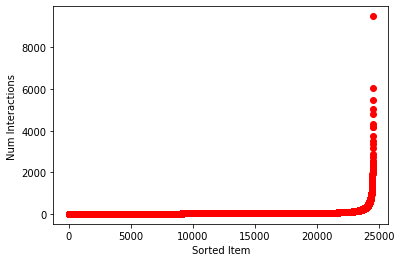

In [32]:
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [33]:
n_items = len(URM_dataframe["ItemID"].unique())
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 63.44
Average per-item interactions for the top 10% popular items 305.72
Average per-item interactions for the least 10% popular items 22.21
Average per-item interactions for the median 10% popular items 34.46


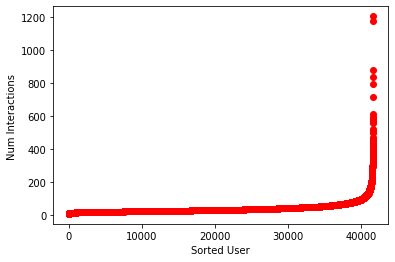

In [34]:
user_activity = np.ediff1d(URM.tocsr().indptr)
user_activity = np.sort(user_activity)


pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

### In order to evaluate our recommender we have to define:
* A splitting of the data in URM_train and URM_test
* An evaluation metric
* A function computing the evaluation for each user

### The splitting of the data is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen. We create two splits:
#### - Train data: we will use this to train our model
#### - Test data: we will use this to evaluate our model

In [35]:
train_test_split = 0.80

n_interactions = URM.nnz


train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])
train_mask

array([ True,  True,  True, ..., False,  True,  True])

In [36]:
URM_train = sps.csr_matrix((URM.data[train_mask],
                            (URM.row[train_mask], URM.col[train_mask])))

URM_train

<41629x24507 sparse matrix of type '<class 'numpy.int64'>'
	with 1311346 stored elements in Compressed Sparse Row format>

In [37]:
test_mask = np.logical_not(train_mask)

URM_test = sps.csr_matrix((URM.data[test_mask],
                            (URM.row[test_mask], URM.col[test_mask])))

URM_test

<41629x24507 sparse matrix of type '<class 'numpy.int64'>'
	with 470200 stored elements in Compressed Sparse Row format>

### Evaluation metric
#### We call items in the test set 'relevant

In [38]:
user_id = 124
relevant_items = URM_test[user_id].indices
relevant_items

array([ 5834, 13738, 14913, 16522])

#### Say that we have a recommendation list such as this

In [39]:
recommended_items = np.array([6060, 1622, 15, 857, 5823])
recommended_items

array([6060, 1622,   15,  857, 5823])

In [40]:
is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
is_relevant

array([False, False, False, False, False])

### Precision: how many of the recommended items are relevant

In [41]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    #Tableau des items recommandés qui sont pertinents
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    #Nombre de items recommandés qui sont pertinents / Nombre total d'items recommandés
    
    return precision_score

In [42]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    #Nombre de items recommandés qui sont pertinents / Nombre total d'items pertinents
    
    return recall_score

In [43]:
def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

### Now that we have the data, we can build our first recommender. We need two things:
* a 'fit' function to train our model
* a 'recommend' function that uses our model to recommend

### Let's start with a random recommender

In [44]:
class RandomRecommender(object):

    def fit(self, URM_train):
           
        self.n_items = URM_train.shape[1]
        #Nombre d'items dans la matrice URM_train
    
    
    def recommend(self, user_id, at=5):
    
        recommended_items = np.random.choice(self.n_items, at)
        #Choix aléatoire de 5 items parmi le nombre d'items dans la matrice URM_train

        return recommended_items

In [45]:
randomRecommender = RandomRecommender()
randomRecommender.fit(URM_train)
#On entraine le modèle sur la matrice URM_train

for user_id in range(10):
    print(randomRecommender.recommend(user_id, at=5))

[17527 22370 12693  8963  7672]
[23328  8689  3054 22424  8464]
[ 2515 14962 17422 17976  9927]
[14377 17572 18695  3449 17583]
[12345 20712 21207 22059 11970]
[ 6120  1069 21885 10220 14872]
[16338  5265  1150 13264 14135]
[22574 15751 22839 15390 14981]
[ 7752 23727 12156  7835   342]
[12378 20697 19934  1909  8272]


### Put all together in an evaluation function and let's test it!

In [46]:
# We pass as paramether the recommender class

def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0


    for user_id in range(URM_test.shape[0]): #Pour chaque utilisateur dans la matrice URM_test

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]] #On récupère les items pertinents pour l'utilisateur
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at) #On récupère les items recommandés pour l'utilisateur
            num_eval+=1 #On incrémente le nombre d'évaluations

            cumulative_precision += precision(recommended_items, relevant_items) #On calcule la précision
            cumulative_recall += recall(recommended_items, relevant_items) #On calcule le rappel
            cumulative_AP += AP(recommended_items, relevant_items) #On calcule la moyenne des précisions
            
    cumulative_precision /= num_eval #On calcule la précision moyenne
    cumulative_recall /= num_eval #On calcule le rappel moyen
    MAP = cumulative_AP / num_eval  #On calcule la moyenne des précisions moyenne
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 


In [47]:
#evaluate_algorithm(URM_test, randomRecommender)

Recommender results are: Precision = 0.0005, Recall = 0.0002, MAP = 0.0002


# Top Popular recommender

#### We recommend to all users the most popular items, that is those with the highest number of interactions
#### In this case our model is the item popularity

In [48]:
class TopPopRecommender(object):

    def fit(self, URM_train):

        item_popularity = np.ediff1d(URM_train.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
    def recommend(self, user_id, at=5):
    
        recommended_items = self.popular_items[0:at]

        return recommended_items



In [49]:
TopPopRecommender = TopPopRecommender()
TopPopRecommender.fit(URM_train)

In [50]:
#evaluate_algorithm(URM_test, TopPopRecommender, at=10)

Recommender results are: Precision = 0.0649, Recall = 0.0568, MAP = 0.0393


In [76]:
submission = submission_sample.copy()
submission_sample.index

RangeIndex(start=0, stop=41116, step=1)

In [81]:
for i in submission_sample.index:
    submission_sample.loc[i, 'item_list'] = ' '.join([str(s) for s in TopPopRecommender.recommend(i, at=10)])
    if i%411==0 :
        print(i/len(submission_sample.index)*100, '%')
    #print(submission['user_id'][i], i)

submission_sample
#submission.to_csv("sample_submission.csv", index=False)

0.0 %
0.9996108570872653 %
1.9992217141745305 %
2.998832571261796 %
3.998443428349061 %
4.998054285436327 %
5.997665142523592 %
6.9972759996108564 %
7.996886856698122 %
8.996497713785388 %
9.996108570872654 %
10.99571942795992 %
11.995330285047183 %
12.99494114213445 %
13.994551999221713 %
14.994162856308979 %
15.993773713396244 %
16.99338457048351 %
17.992995427570776 %
18.992606284658038 %
19.992217141745307 %
20.991827998832573 %
21.99143885591984 %
22.991049713007104 %
23.990660570094366 %
24.990271427181632 %
25.9898822842689 %
26.989493141356164 %
27.989103998443426 %
28.988714855530695 %
29.988325712617957 %
30.987936569705226 %
31.98754742679249 %
32.98715828387975 %
33.98676914096702 %
34.98637999805428 %
35.98599085514155 %
36.985601712228814 %
37.985212569316076 %
38.984823426403345 %
39.984434283490614 %
40.98404514057788 %
41.983655997665146 %
42.98326685475241 %
43.98287771183968 %
44.98248856892694 %
45.98209942601421 %
46.98171028310147 %
47.98132114018873 %
48.98093199

,user_id,item_list
0,0,4744 14543 10697 2759 2425 842 2027 3072 7697 66
1,1,4744 14543 10697 2759 2425 842 2027 3072 7697 66
2,2,4744 14543 10697 2759 2425 842 2027 3072 7697 66
3,3,4744 14543 10697 2759 2425 842 2027 3072 7697 66
4,4,4744 14543 10697 2759 2425 842 2027 3072 7697 66
...,...,...
41111,41624,4744 14543 10697 2759 2425 842 2027 3072 7697 66
41112,41625,4744 14543 10697 2759 2425 842 2027 3072 7697 66
41113,41626,4744 14543 10697 2759 2425 842 2027 3072 7697 66
41114,41627,4744 14543 10697 2759 2425 842 2027 3072 7697 66


In [ ]:
submission_sample.to_csv("sample_submission.csv", index=False)